In [1]:
# This is a test to check that spacy installed right the greek model and lemmatization in greek works.

import spacy
nlp = spacy.load('el_core_news_sm')

conference_help_text = ('καλημέρα ΠΑΙΖΩ παιζει παιζουμε παίζετε')
conference_help_doc = nlp(conference_help_text)
for token in conference_help_doc:
    print (token, token.lemma_)

'''
Should get:

καλημέρα καλημέρα
ΠΑΙΖΩ παιζω
παιζει παιζω
παιζουμε παιζω
παίζετε παίζω
'''

καλημέρα καλημέρα
ΠΑΙΖΩ παιζω
παιζει παιζω
παιζουμε παιζω
παίζετε παίζω


'\nShould get:\n\nκαλημέρα καλημέρα\nΠΑΙΖΩ παιζω\nπαιζει παιζω\nπαιζουμε παιζω\nπαίζετε παίζω\n'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


--- Dataset before preprocessing
         genre                                             lyrics
2    Ρεμπέτικο  Μια στενοχώρια που έχω απόψε, απ την καρδιά μ...
3      Έντεχνο  Κάποιο βράδυ σου χα πει πως θέλω να γυρίσω όλο...
4      Αφήγηση  Εμπρός ν αρχίσει ο χορός, ν αρχίσουνε οι τρέ...
5     Μπαλάντα  Τώρα, τώρα που σήμανε η ώρα, κάνε κουράγιο και...
6  traditional  Μέσα στις θάλασσες γυρνώ γι' αυτά τα δυο σου μ...
7         folk  Μες στα μαλλιά σου κρέμασα άστρα να σε φωτίζου...
8          rap  Θα πολεμήσω μέχρι θανάτου σ'αυτή την μάχη σωστ...
9     Μπαλάντα  Du ruafst mi an im Winter, und i sag, dass es...
--- Dataset after preprocessing
  genre                                             lyrics
0   rap   ΠΟΛΕΜΗΣΩ ΜΕΧΡΙ ΘΑΝΑΤΟ Σ' ΑΥΤΗ ΜΑΧΗ ΣΩΣΤΟΣ ΛΑΘ...
1   rap   ΜΟΥ ΛΕΣ ΘΕΛΩ ΕΞΗΓΗΣΕΙ ΑΠΑΝΤΗΣΕΙ ΖΗΤΩ ΘΕΛΕΙ ΠΙ...
2   rap   ΕΡΧΟΜΑΙ ΣΤΙΓΜΗ ΠΟΛΛΟΣ ΚΑΘΡΕΦΤΗ ΚΟΙΤΙΕΣΑΙ ΑΝΑΡ...
3   rap   ΟΤΑΝ ΣΕΙΧΑ ΠΡΩΤΟΔΩ ΚΑΤΙ ΖΩΗ ΜΟΥ ΕΙΛΙΚΡΙΝΑ ΕΧ...
4   rap   ΠΡΙΝ ΓΝΩΡΙΣΩ ΗΜΟΥΝΟΣ ΣΠΙΘΑ ΕΤΟΙΜΗ ΣΒ

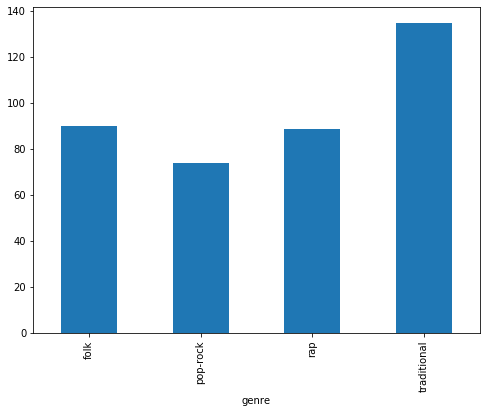

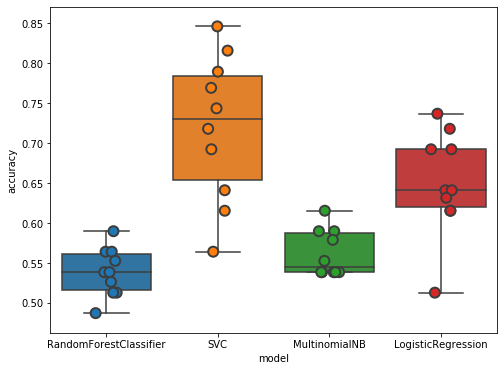

 --- Classifier accuracies on 10 fold Cross-Validation
model
LogisticRegression        0.649663
MultinomialNB             0.561876
RandomForestClassifier    0.538664
SVC                       0.719501
Name: accuracy, dtype: float64
--- Dense representation of tf/idf data
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
--- Scaled token count per song
[[0.28421462 0.14307932 0.17418351 0.64813375 0.07115086 0.50816485
  0.14502333 0.36391913 0.79004666 0.16874028 0.11353033 0.18390358
  0.15085537 0.0785381  0.23094868 0.29237947 0.218507   0.23055988
  0.53810264 0.40979782 0.20606532 0.19401244 0.13374806 0.89852255
  0.1714619  0.41757387 0.20956454 0.24727838 0.11858476 0.07037325]]
--- New feature "Token Count" added to data
[[0.         0.         0.         ... 0.         0.         0.28421462]
 [0.         0.         0.         ... 0.         0.         0.14307932]
 [0.    

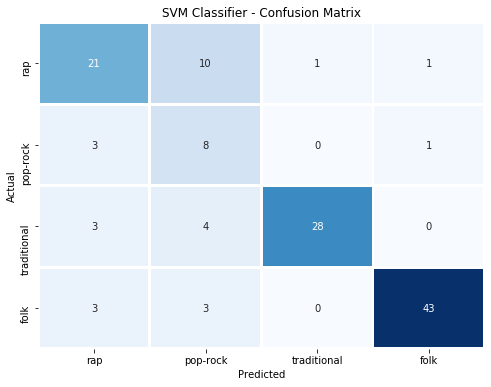

              precision    recall  f1-score   support

         rap       0.64      0.70      0.67        30
    pop-rock       0.67      0.32      0.43        25
 traditional       0.80      0.97      0.88        29
        folk       0.88      0.96      0.91        45

    accuracy                           0.78       129
   macro avg       0.75      0.74      0.72       129
weighted avg       0.76      0.78      0.75       129



In [29]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics, svm, model_selection, preprocessing
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack, coo_matrix
from sklearn.model_selection import cross_val_score

import string

import spacy
nlp = spacy.load('el_core_news_sm')

# This method receives a list of strings and returns 
# a single string of all the elemnets with a white space in between 
def listToString(s):  
    str1 = ""   
    for element in s:  
        str1 += " "+element      
    return str1

# This method removes accentuation from a string
import unicodedata 
def strip_accents(s): 
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# This method receives our greek lyrics dataset as a dataframe and returns a dataframe of the same format
# after it performs the following procedures :
# Keeping certain genres and grouping them under relative tags, stop word, punctuation and accentuation removal,
# greek lemmatization, conversion to upper case
def preprocess(df):

    booleanDF = (df.groupby(['genre']).count()>10)
    genreToRemove = booleanDF[booleanDF['title'] == False]
    genreToRemove = genreToRemove.reset_index()

    for index, row in genreToRemove.iterrows():
        delete_row = df[df['genre'] == row['genre']].index
        df.drop(delete_row, inplace=True)

    rapList = ["RAP","Hip Hop","Ελληνικό Ραπ","Ελληνικό χιπ χοπ"]
    pop_rockList = ["Ποπ", "Ελληνικό Ροκ", "Ελληνικό Ποπ"]
    traditionalList = ["Παραδοσιακό Κρήτης", "Παραδοσιακό Μικράς Ασίας", "Παραδοσιακό", "Παραδοσιακό Κύπρου", "Δημοτικό", "Νησιώτικο"]
    folkList = ["Λαικό", "Ελληνικό λαικό", "Ελληνική μπαλάντα", "Λαικό Μπαλάντα"]

    for index, row in df.iterrows():
        if(row['genre'] in rapList):
            row['genre'] = "rap"
        elif(row['genre'] in pop_rockList):
            row['genre'] = "pop-rock"
        elif(row['genre'] in traditionalList):
            row['genre'] = "traditional"
        elif(row['genre'] in folkList):
            row['genre'] = "folk"    

    data = df[df['genre'] == "rap"]
    data = data.append(df[df['genre'] == "pop-rock"], ignore_index=True)
    data = data.append(df[df['genre'] == "traditional"], ignore_index=True)
    data = data.append(df[df['genre'] == "folk"], ignore_index=True)

    data = data.reset_index()
    data = data.drop(['index'], axis=1)

    import nltk
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    greek_stopwords_lower = set(stopwords.words('greek'))
    greek_stopwords = list()
    for val in greek_stopwords_lower: 
        greek_stopwords.append(str(val).upper())
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    for index, row in data.iterrows():
        conference_help_text = (str(row['lyrics'])) # Lemmatization
        conference_help_doc = nlp(conference_help_text)
        limaList = []
        for token in conference_help_doc:
            #print(str(token).upper())        
            if(str(token).upper() not in (greek_stopwords + list(punctuations))): # stop word and punctuation removal
                limaList.append(strip_accents(str(token.lemma_).upper())) # Uppercase token, lemma, remove accent

        data.iloc[index]['lyrics'] = listToString(limaList)        
     
    return data


dataset = pd.read_csv('dataset/greekLyrics_ansi.csv', delimiter=';', encoding='iso8859_7')

df = preprocess(dataset)

print("--- Dataset before preprocessing")
print(dataset[['genre','lyrics']].head(8))

print("--- Dataset after preprocessing")
print(df[['genre','lyrics']].head(8))

# --- Plotting of all genres of our dataset and the number of songs per genre
fig = plt.figure(figsize=(8, 6))
df.groupby('genre').title.count().plot.bar(ylim=0)
plt.show()

# --- Tf/idf tranformation of a dataframe of strings
tfidfVec = TfidfVectorizer()
X_total_tfidf = tfidfVec.fit_transform(df['lyrics'])
y_total = df['genre']

totalLyricsCountList = list() # A list that keeps the number of tokens of each song
scaledTotalLyricsCountList = list() # A list of scaled values of the above list
for element in df['lyrics']: # Counting and populating the list of counts
    totalLyricsCountList.append(len(element))
    
maxTokenCount = max(totalLyricsCountList) # Keeping the max token count of all songs

for element in totalLyricsCountList: # Populating the scaled version of the list
    scaledTotalLyricsCountList.append(element/maxTokenCount)

X_total_tfidf_dense = X_total_tfidf.todense() # Converting the sparse tfidf array to dense
totalLyricsCountArray = np.asarray(scaledTotalLyricsCountList) # List to array conversion
totalLyricsCountArray = np.expand_dims(totalLyricsCountArray, axis=0) # Adding a new dimension to convert 1-D to 2-D array
# Column wise concatenation of the tfidf (data) array and the "Token Count" (extra feature) array
concatDenseTotalArray = np.concatenate((X_total_tfidf_dense, totalLyricsCountArray.T), axis=1) 
X_total_tfidf_concat = coo_matrix(concatDenseTotalArray) # Converting the dense array back to sparse

# --- Listing classifiers to be tested on the data
models = [ 
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    svm.SVC(kernel='linear', C = 100),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
]
CV = 10 # 10 Fold Cross-Validation
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_total_tfidf_concat, y_total, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model', 'fold_idx', 'accuracy'])

# --- Plotting the classifier accuracies in a box plot
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x='model', y='accuracy', data=cv_df)
sns.stripplot(x='model', y='accuracy', data=cv_df,
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

print(" --- Classifier accuracies on 10 fold Cross-Validation")
print(cv_df.groupby('model').accuracy.mean())

# --- Train test split in order to train some models below
X_train, X_test, y_train, y_test = model_selection.train_test_split(df['lyrics'], df['genre'], test_size=0.33, random_state=10, stratify = df['genre'])  

# --- Adding extra feature "Token Count" to train data that is the number of tokens of the lyrics each song. 
# Detailed commenting above
trainLyricsCountList = list()
scaledTrainLyricsCountList = list()
tfidfVec = TfidfVectorizer()
X_train_tfidf = tfidfVec.fit_transform(X_train)
for element in X_train:
    trainLyricsCountList.append(len(element))
    
maxTokenCount = max(trainLyricsCountList)

for element in trainLyricsCountList:
    scaledTrainLyricsCountList.append(element/maxTokenCount)

X_train_tfidf_dense = X_train_tfidf.todense()
trainLyricsCountArray = np.asarray(scaledTrainLyricsCountList)
trainLyricsCountArray = np.expand_dims(trainLyricsCountArray, axis=0)

print("--- Dense representation of tf/idf data")
print(X_train_tfidf_dense)
print("--- Scaled token count per song")
print(trainLyricsCountArray[:,0:30])
concatDenseTrainArray = np.concatenate((X_train_tfidf_dense, trainLyricsCountArray.T), axis=1)
print("--- New feature \"Token Count\" added to data")
print(concatDenseTrainArray)
X_train_tfidf_concat = coo_matrix(concatDenseTrainArray)
print("--- Sparse data representation")
print(X_train_tfidf_concat)


# --- Adding extra feature "Token Count" to test data that is the number of tokens of the lyrics each song. 
# Detailed commenting above
testLyricsCountList = list()
scaledTestLyricsCountList = list()
# We use the tfidf vectorizer that we previously fitted on train data. We should not fit again on test data 
# because that would lead to a different vocabulary. We also should not fit_transform all the data at once, as
# the vectorizer would fit also the test data and that would be cheating.
X_test_tfidf = tfidfVec.transform(X_test) 
for element in X_test:
    testLyricsCountList.append(len(element))

for element in testLyricsCountList:
    scaledTestLyricsCountList.append(element/maxTokenCount)    
    
X_test_tfidf_dense = X_test_tfidf.todense()
testLyricsCountArray = np.asarray(scaledTestLyricsCountList)
testLyricsCountArray = np.expand_dims(testLyricsCountArray, axis=0)

concatDenseTestArray = np.concatenate((X_test_tfidf_dense, testLyricsCountArray.T), axis=1)
X_test_tfidf_concat = coo_matrix(concatDenseTestArray)


# --- Fitting of a SVM classifier
model = svm.SVC(kernel='linear', C = 100)
model.fit(X_train_tfidf_concat, y_train)

y_pred = model.predict(X_test_tfidf_concat)

print("--- Metrics of SVM classifier with kernel='linear'and C = 100 :")
print("recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
print("prec: ", metrics.precision_score(y_test, y_pred, average='macro'))
print("f1: ", metrics.f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
print("acc: ", metrics.accuracy_score(y_test, y_pred))

confusionMatrix = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
hm = sns.heatmap(confusionMatrix.T, cmap="Blues", linewidths=2, square=False, annot=True, cbar=False, fmt='d',
                 xticklabels=df["genre"].unique(), yticklabels=df["genre"].unique())
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.title('SVM Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(metrics.classification_report(y_test, y_pred, target_names=df['genre'].unique()))


In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical 

modelDeepNN = Sequential()
modelDeepNN.add(Dense(13308, input_dim=6644, activation="relu"))
modelDeepNN.add(Dense(13308, input_dim=6644, activation="relu"))
modelDeepNN.add(Dense(4, activation="softmax"))
modelDeepNN.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

modelDeepNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 13308)             88431660  
_________________________________________________________________
dense_5 (Dense)              (None, 13308)             177116172 
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 53236     
Total params: 265,601,068
Trainable params: 265,601,068
Non-trainable params: 0
_________________________________________________________________


In [13]:
y_OneHotEn = to_categorical(pd.factorize(y_train)[0], num_classes=4)
modelDeepNN.fit(concatDenseTrainArray,y_OneHotEn,epochs = 20, verbose = 2)



Epoch 1/20
 - 1278s - loss: 0.1990 - acc: 0.9228
Epoch 2/20
 - 1194s - loss: 0.0161 - acc: 0.9961
Epoch 3/20
 - 1282s - loss: 6.5805e-05 - acc: 1.0000
Epoch 4/20
 - 1098s - loss: 7.2457e-05 - acc: 1.0000
Epoch 5/20
 - 1153s - loss: 4.6652e-05 - acc: 1.0000
Epoch 6/20
 - 1293s - loss: 2.7109e-05 - acc: 1.0000
Epoch 7/20
 - 1295s - loss: 1.9934e-05 - acc: 1.0000
Epoch 8/20
 - 1319s - loss: 1.3696e-05 - acc: 1.0000
Epoch 9/20
 - 1337s - loss: 1.0813e-05 - acc: 1.0000
Epoch 10/20
 - 1106s - loss: 9.2315e-06 - acc: 1.0000
Epoch 11/20
 - 1149s - loss: 8.1905e-06 - acc: 1.0000
Epoch 12/20
 - 1194s - loss: 7.1771e-06 - acc: 1.0000
Epoch 13/20
 - 1285s - loss: 6.4617e-06 - acc: 1.0000
Epoch 14/20
 - 1202s - loss: 5.9264e-06 - acc: 1.0000
Epoch 15/20
 - 1122s - loss: 5.3697e-06 - acc: 1.0000
Epoch 16/20
 - 8639s - loss: 5.0076e-06 - acc: 1.0000
Epoch 17/20
 - 1119s - loss: 4.6261e-06 - acc: 1.0000
Epoch 18/20
 - 1234s - loss: 4.3239e-06 - acc: 1.0000
Epoch 19/20
 - 1359s - loss: 4.0739e-06 - acc

In [30]:

y_pred = modelDeepNN.predict_classes(concatDenseTestArray)
print(y_pred)
print(metrics.confusion_matrix(pd.factorize(y_test)[0],y_pred))
print(metrics.classification_report(pd.factorize(y_test)[0],y_pred))

AttributeError: 'SVC' object has no attribute 'predict_classes'